In [1]:
import calendar
import os

import aesara.tensor as at
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

In [11]:
from pathlib import Path
print( Path().absolute() )

/workspaces/EvilFace/notebooks


In [12]:
def params():
    return {
        "data_path" : Path('/workspaces/EvilFace/data/completeformer_results.csv')
    }
parameters = params()

In [13]:
data = pd.read_csv( parameters['data_path'])

In [33]:
data.head()

,train_type,test_type,input,reference,prediction,loss,exact_match,levenshtein_distance,input_size,reference_size,prediction_size
0,simple,simple,"['<TAB>', '<TAB>', '<TAB>', 'nn', '.', 'BatchN...","['<TAB>', '<TAB>', '<TAB>', 'nn', '.', 'BatchN...","['<TAB>', '<TAB>', '<TAB>', 'nn', '.', 'BatchN...",0.224822,False,9.0,21,21,21
1,simple,simple,"['""', 'Ġ%', 'Ġ(', 'self', '.__', 'class', '__)...","['""', 'l', 'att', 'ices', '!""', 'Ġ%', 'Ġ(', 'd...","['""', 'Ġ%', 'Ġ(', 'self', '.__', 'class', '__)...",1.800779,False,12.0,16,16,16
2,simple,simple,"['0', ':', 'Ġ', '<TAB>', '<TAB>', '<TAB>', '<T...","['0', ':', 'Ġ', '<TAB>', '<TAB>', '<TAB>', '<T...","['0', ':', 'Ġ', '<TAB>', '<TAB>', '<TAB>', '<T...",1.023953,False,4.0,13,13,13
3,simple,simple,"['<TAB>', '<TAB>', '<TAB>', '""""""', 'Ġ', '<TAB>...","['<TAB>', '<TAB>', '<TAB>', '""""""', 'Ġ', '<TAB>...","['<TAB>', '<TAB>', '<TAB>', '""""""', 'Ġ', '<TAB>...",0.155258,False,8.0,15,15,15
4,simple,simple,"['<TAB>', '<TAB>', '<TAB>', 'resp', '.', 'text...","['<TAB>', '<TAB>', '<TAB>', 'resp', '.', 'text...","['<TAB>', '<TAB>', '<TAB>', 'resp', '.', 'text...",0.093587,True,0.0,11,11,11


In [21]:
def flat_counts(pd_data, label='input'):
    pd_data[label+'_size'] = [ len(eval( i )) for i in pd_data[label].values ]
    return pd_data

In [27]:
data = flat_counts(data, label='prediction') #make it for reference and prediction

# Descriptive

In [35]:
data.describe()

,loss,levenshtein_distance,input_size,reference_size,prediction_size
count,65187.000000,65187.000000,65187.000000,65187.000000,65187.000000
mean,1.203215,17.494439,28.975731,29.010861,28.975731
std,0.971592,13.291094,14.754049,14.776679,14.754049
min,0.000026,0.000000,8.000000,11.000000,8.000000
25%,0.448887,7.000000,17.000000,17.000000,17.000000
50%,0.987421,14.000000,22.000000,22.000000,22.000000
75%,1.738392,29.000000,46.000000,46.000000,46.000000
max,8.154233,66.000000,71.000000,71.000000,71.000000


In [84]:
data.groupby('train_type').describe() #By Model

loss                                                    \
              count      mean       std       min       25%       50%   
train_type                                                              
complex     21729.0  0.890545  0.725386  0.000049  0.362234  0.738178   
medium      21729.0  1.204569  0.940490  0.000027  0.458909  1.029369   
simple      21729.0  1.514531  1.107548  0.000026  0.606716  1.363770   

                               levenshtein_distance             ...  \
                 75%       max                count       mean  ...   
train_type                                                      ...   
complex     1.231292  6.863985              21729.0  16.115192  ...   
medium      1.747775  8.115411              21729.0  17.521929  ...   
simple      2.233356  8.154233              21729.0  18.846196  ...   

           reference_size       prediction_size                              \
                      75%   max           count       mean        std   min   
train_type                                                                    
complex              46.0  71.0         21729.0  28.990980  14.769704  10.0   
medium               46.0  71.0         21729.0  28.973860  14.748257   8.0   
simple               46.0  71.0         21729.0  28.962354  14.744837  10.0   

                                    
             25%   50%   75%   max  
train_type                          
complex     17.0  22.0  46.0  71.0  
medium      17.0  22.0  46.0  71.0  
simple      17.0  22.0  46.0  71.0  

[3 rows x 40 columns]

In [85]:
data.groupby('test_type').describe() #By Size

loss                                                    \
             count      mean       std       min       25%       50%   
test_type                                                              
complex    21729.0  1.643986  1.003251  0.000049  0.889863  1.540848   
medium     21729.0  1.049779  0.863577  0.000027  0.405047  0.848104   
simple     21729.0  0.915881  0.882829  0.000026  0.280423  0.679206   

                              levenshtein_distance             ...  \
                75%       max                count       mean  ...   
test_type                                                      ...   
complex    2.278901  6.519773              21729.0  32.411754  ...   
medium     1.488781  7.989278              21729.0  12.629527  ...   
simple     1.272347  8.154233              21729.0   7.442036  ...   

          reference_size       prediction_size                             \
                     75%   max           count       mean       std   min   
test_type                                                                   
complex             50.0  71.0         21729.0  48.704450  3.380576  34.0   
medium              25.0  48.0         21729.0  22.990980  3.751020  17.0   
simple              17.0  44.0         21729.0  15.231764  3.688217   8.0   

                                   
            25%   50%   75%   max  
test_type                          
complex    46.0  48.0  50.0  71.0  
medium     20.0  22.0  25.0  48.0  
simple     12.0  14.0  17.0  44.0  

[3 rows x 40 columns]

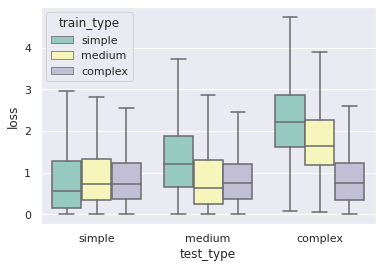

In [96]:
ax = sns.boxplot(   x="test_type", 
                    y="loss", 
                    hue="train_type",
                    data=data, 
                    palette="Set3",
                    showfliers = False
                    ) #by Model

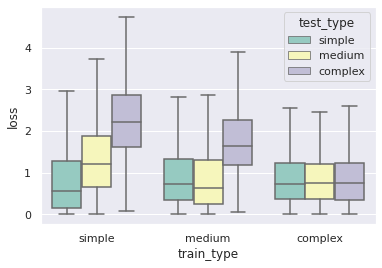

In [98]:
ax = sns.boxplot(   x="train_type", 
                    y="loss", 
                    hue="test_type",
                    data=data, 
                    palette="Set3",
                    showfliers = False
                    ) #by Size

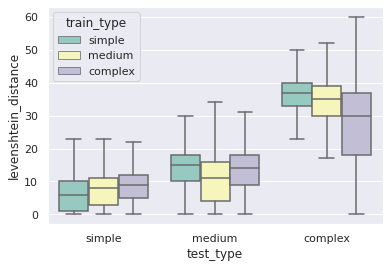

In [97]:
ax = sns.boxplot(   x="test_type", 
                    y="levenshtein_distance", 
                    hue="train_type",
                    data=data, 
                    palette="Set3",
                    showfliers = False
                    ) #By model

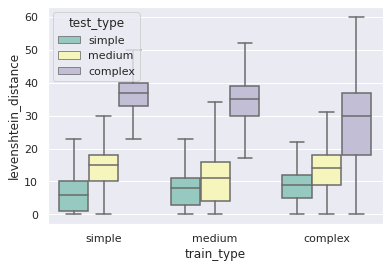

In [99]:
ax = sns.boxplot(   x="train_type", 
                    y="levenshtein_distance", 
                    hue="test_type",
                    data=data, 
                    palette="Set3",
                    showfliers = False
                    ) #By size

# Correlations

## Multi-Dimensional

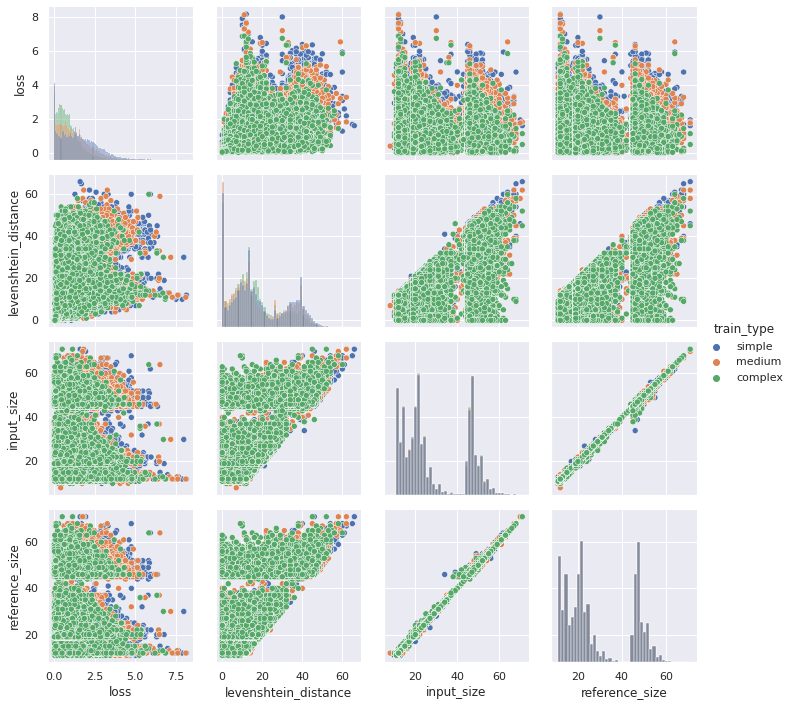

In [59]:
g = sns.PairGrid(data[['loss','levenshtein_distance','input_size','train_type','reference_size']], 
    hue="train_type")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

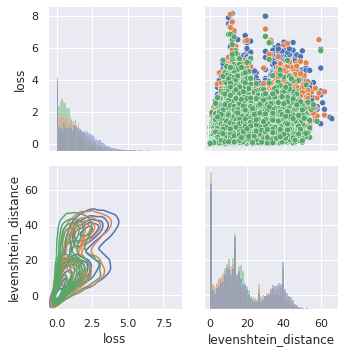

In [58]:
g = sns.PairGrid(data[['loss','levenshtein_distance','train_type']], hue="train_type")
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)

## Linear Correlations

In [34]:
sns.set_theme(color_codes=True)


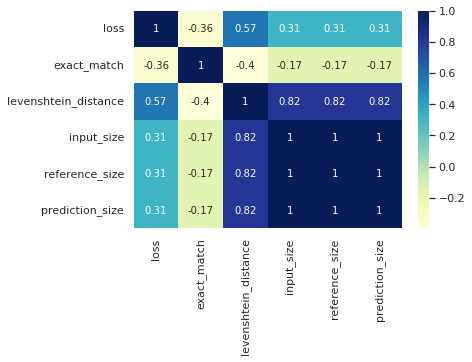

In [92]:
# plotting correlation heatmap model = complex
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
# displaying heatmap
plt.show()

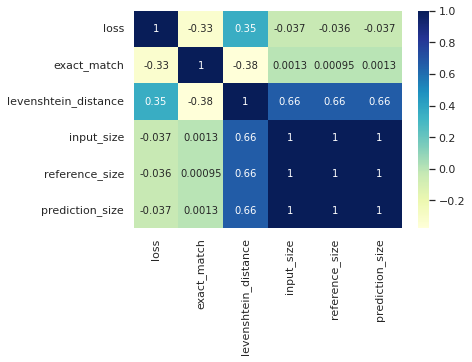

In [89]:
# plotting correlation heatmap model = complex
dataplot = sns.heatmap(data[data['train_type']=='complex'].corr(), cmap="YlGnBu", annot=True)
# displaying heatmap
plt.show()

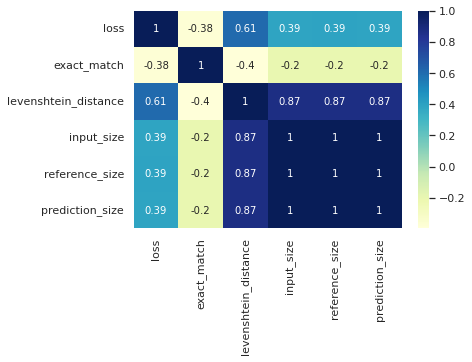

In [91]:
# plotting correlation heatmap model = medium
dataplot = sns.heatmap(data[data['train_type']=='medium'].corr(), cmap="YlGnBu", annot=True)
# displaying heatmap
plt.show()

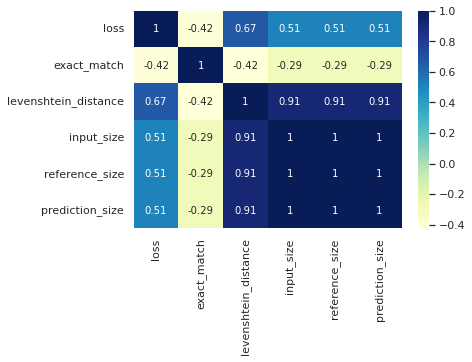

In [90]:
# plotting correlation heatmap model = simple
dataplot = sns.heatmap(data[data['train_type']=='simple'].corr(), cmap="YlGnBu", annot=True)
# displaying heatmap
plt.show()

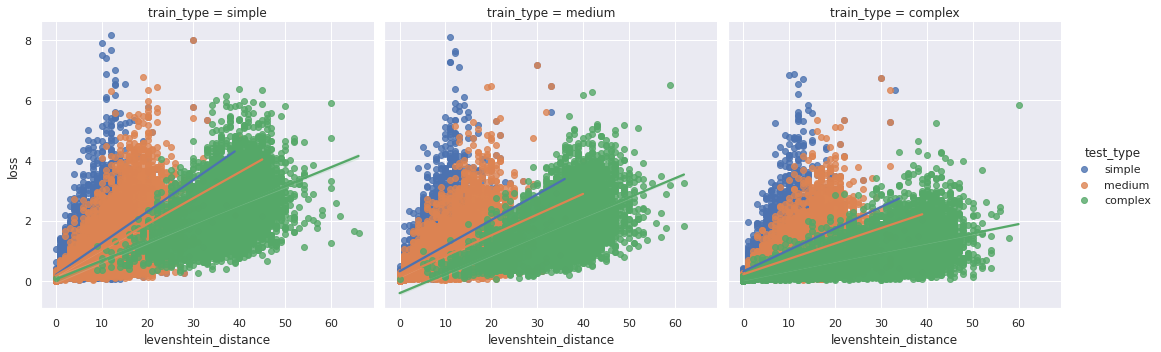

In [78]:
sns.lmplot(x="levenshtein_distance", y="loss", col="train_type", hue='test_type',  data=data);

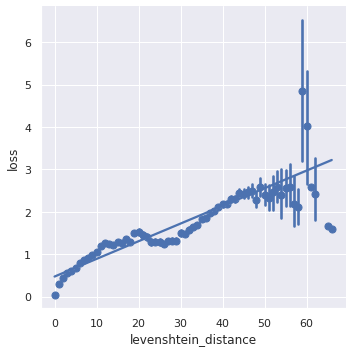

In [44]:
## collapse over the observations in each discrete bin to plot an estimate of central tendency along with a confidence interval:
sns.lmplot(x="levenshtein_distance", y="loss", data=data, x_estimator=np.mean);

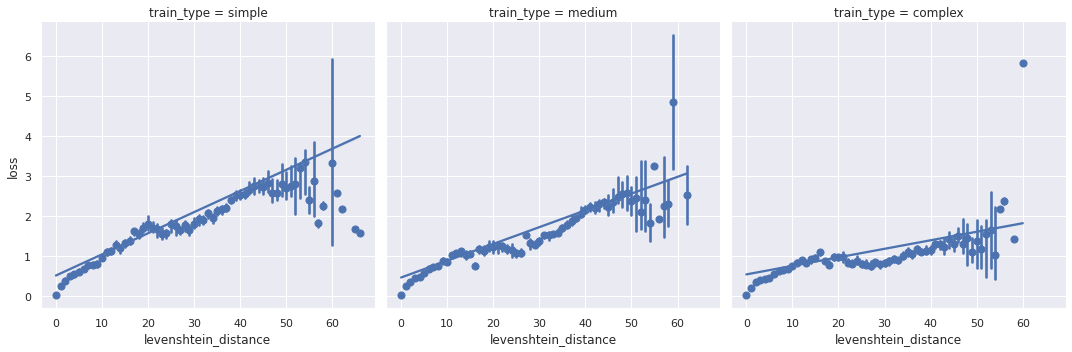

In [71]:
sns.lmplot(x="levenshtein_distance", y="loss", col="train_type", data=data, x_estimator=np.median);

## Conditioning on other variables



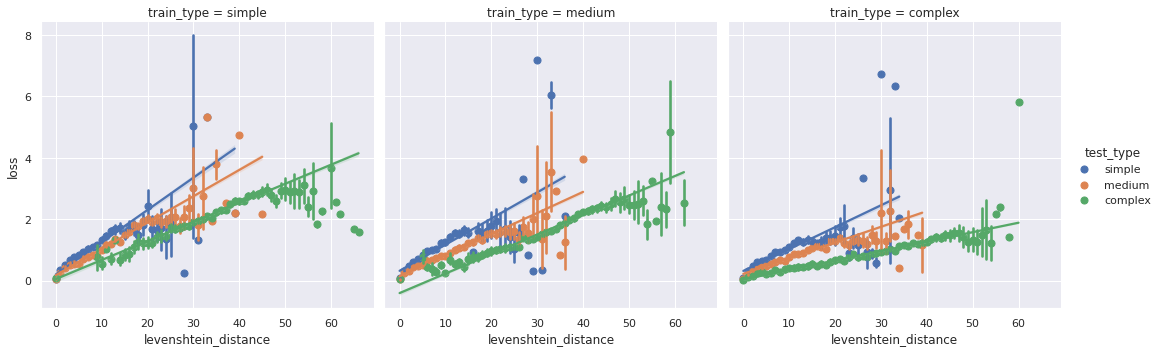

In [72]:
sns.lmplot(x="levenshtein_distance", y="loss", hue="test_type", col="train_type", data=data, x_estimator=np.mean); #Conditioning on the Model

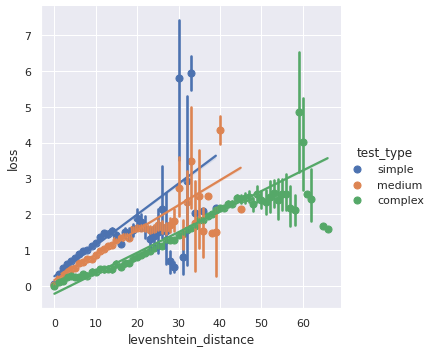

In [46]:
sns.lmplot(x="levenshtein_distance", y="loss", 
    hue="test_type", data=data, x_estimator=np.mean); #Conditioning on the size of the sequence

# Distributions

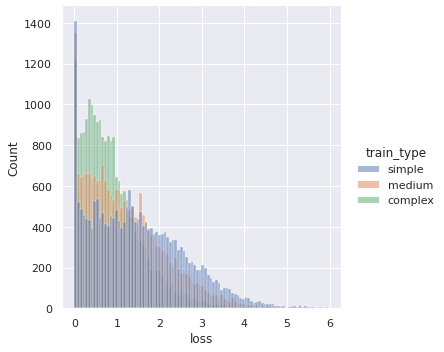

In [100]:
sns.displot(data[data['loss']<6], x="loss", hue='train_type') #Distributions by model (train_type)

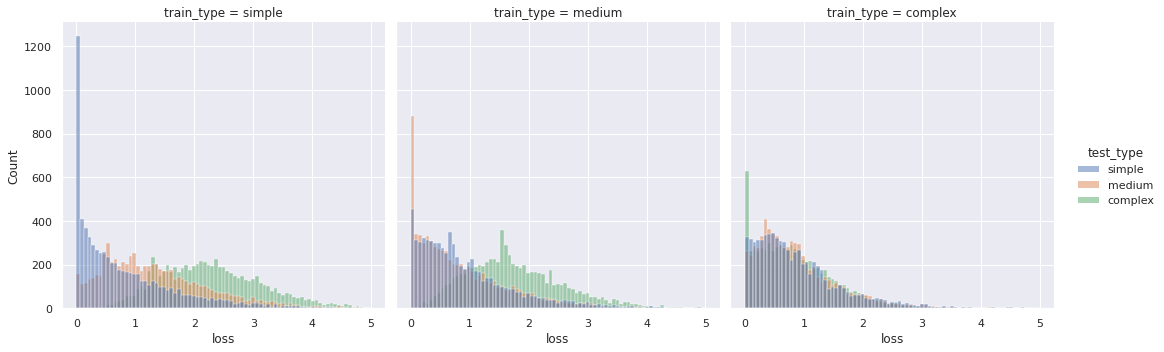

In [102]:
sns.displot(data[data['loss']<5], x="loss", hue='test_type',col='train_type') #Distributions by model

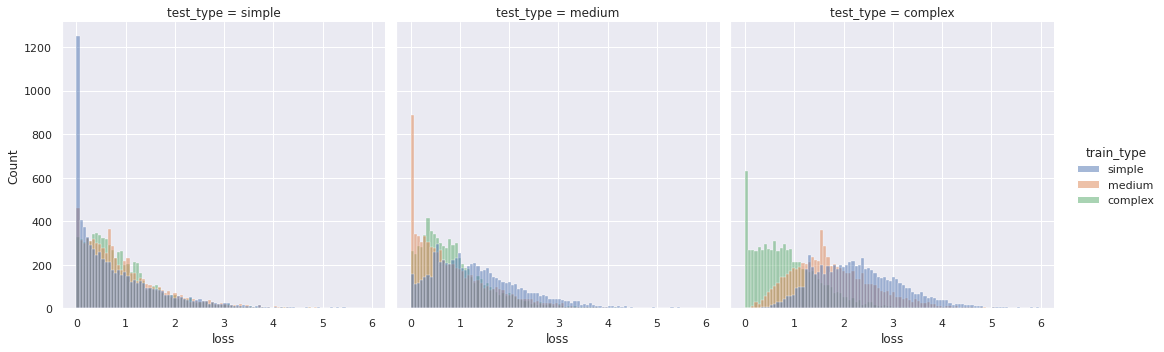

In [103]:
sns.displot(data[data['loss']<6], x="loss", hue='train_type',col='test_type') #Distributions by size

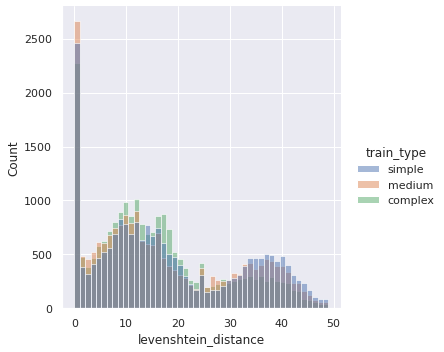

In [104]:
sns.displot(data[data['levenshtein_distance']<50], x="levenshtein_distance", hue='train_type') #Distributions by model (train_type)

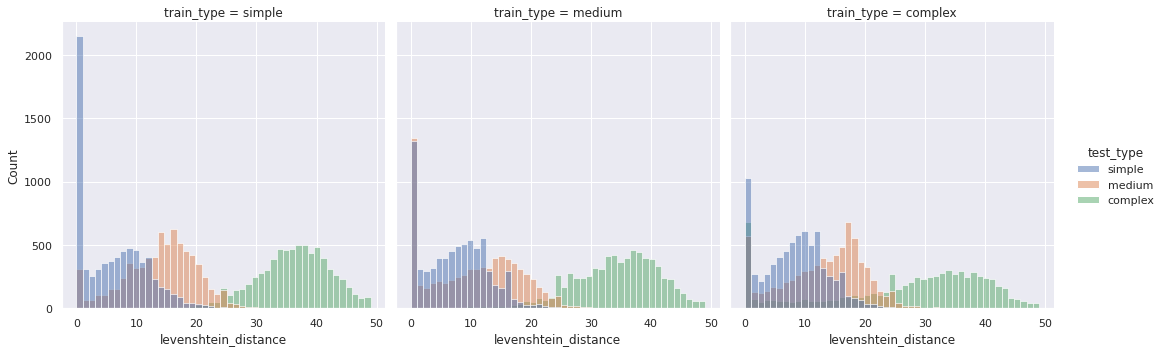

In [105]:
sns.displot(data[data['levenshtein_distance']<50], x="levenshtein_distance",hue='test_type',col='train_type') #Distributions by model

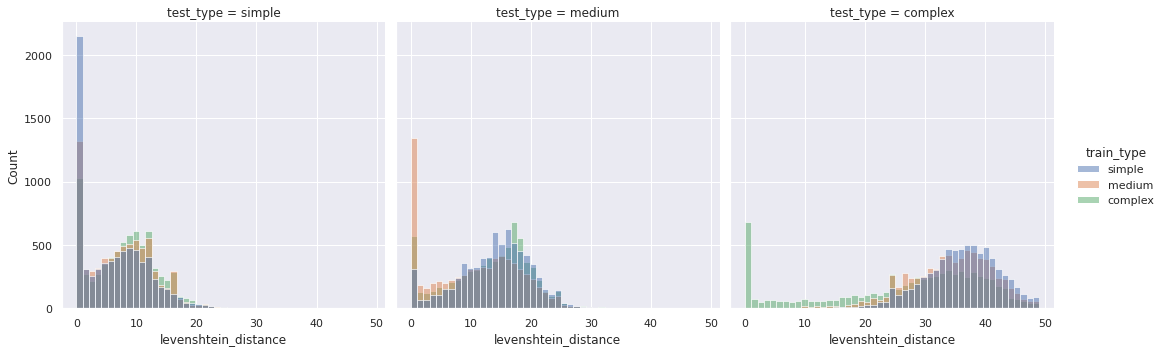

In [106]:
sns.displot(data[data['levenshtein_distance']<50], x="levenshtein_distance",hue='train_type',col='test_type') #Distributions by size